In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import numpy as np
import math
import matplotlib.pyplot as plt

import time

In [ ]:
# torch.manual_seed(42)

In [15]:
# device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
print(f'device: {device}')

device: cpu


In [16]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
    
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')

        self.layers = layers
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

        self.H1 = self.linears[0]

        
    'forward pass'
    def forward(self,x,y):              
        
        # for i in range(len(self.layers)-2):
        #     z = self.linears[i](a)
        #     a = self.activation(z)

        a = torch.cat([x,y], dim = 1)    #(N,2)

        for i in range(len(self.layers)-2):
            m = self.linears[i](a)
            a = self.activation(m)


            
        b = self.linears[-1](a) 
         
        return b
    
    def forward_direct(self, x,y):
        
        m = torch.cat([x,y], dim = 1)    #(N,2)    

        W1 = self.linears[0].weight    # (20,2)

        H_x = W1[:, 0].unsqueeze(0)      # (1,20)
        F_x = torch.zeros_like(H_x)

        H_y = W1[:, 1].unsqueeze(0)      # (1,20)
        F_y = torch.zeros_like(H_y)


        

        for i in range(len(self.layers)-2):
            L = self.linears[i](m)            # (N,20)
            m = self.activation(L)            # (N,20)
            m_1 = 1.0-torch.square(m)         # (N,20)

            G_x = m_1*H_x     #\sigma'(L)*H   # (N,20)
            G_y = m_1*H_y
            

            C_x = (-2*m + 2*torch.pow(m,3))*H_x*H_x
            C_y = (-2*m + 2*torch.pow(m,3))*H_y*H_y
          


            E_x = C_x + m_1*F_x    # (N,20)
            E_y = C_y + m_1*F_y    # (N,20)
           


            H_x = torch.matmul(G_x,self.linears[i+1].weight.t())
            F_x = torch.matmul(E_x,self.linears[i+1].weight.t())

            H_y = torch.matmul(G_y,self.linears[i+1].weight.t())
            F_y = torch.matmul(E_y,self.linears[i+1].weight.t())


        m = self.linears[-1](m)
         
        # return z, H_x, H_y, H_t, F_x, F_y, F_t
        return m, H_x, H_y, F_x, F_y


    # # TENSORIZED
    
    
    # def forward_direct(self, x,t):
        
    #     z = torch.cat([x,t], dim = 1)    #(N,2)      N = 90000
    #     N = z.size(0)

    #     W1 = self.linears[0].weight    # (20,2)

    #     H = W1.unsqueeze(0).expand(N,-1,-1).contiguous()     #(N,20,2)
    #     F = torch.zeros_like(H)

    #     # H_x = W1[:, 0].unsqueeze(0)      # (1,20)
    #     # F_x = torch.zeros_like(H_x)

    #     # H_t = W1[:, 1].unsqueeze(0)      # (1,20)
    #     # F_t = torch.zeros_like(H_t)
        

    #     for i in range(len(self.layers)-2):
    #         L = self.linears[i](z)            # (N,20)
    #         z = self.activation(L)            # (N,20)
    #         z_1 = 1.0-torch.square(z)         # (N,20)
    #         z_1 = z_1.unsqueeze(-1)           # (N,20,1)

    #         G = z_1*H     #\sigma'(L)*H   # (N,20,2)

    #         # G_x = z_1*H_x     #\sigma'(L)*H   # (N,20)
    #         # G_t = z_1*H_t                     # (N,20)

    #         z_2 = (-2*z + 2*torch.pow(z,3))   #(N,20)
    #         z_2 = z_2.unsqueeze(-1)           # (N,20,1)

    #         C = z_2*H*H                       # (N,20,2)




    #         # C_x = (-2*z + 2*torch.pow(z,3))*H_x*H_x
    #         # C_t = (-2*z + 2*torch.pow(z,3))*H_t*H_t

    #         E = C + z_1*F                     # (N,20,2)     

    #         # E_x = C_x + z_1*F_x    # (N,50)
    #         # E_t = C_t + z_1*F_t    # (N,50)

    #         H = torch.matmul(G.transpose(1, 2),self.linears[i+1].weight.t()).transpose(1, 2)     # (N,2,20) * (20,1)  = (N,2,1).t() = (N,1,2)
    #         F = torch.matmul(E.transpose(1, 2),self.linears[i+1].weight.t()).transpose(1, 2)     # (N,1,2)


    #         # H_x = torch.matmul(G_x,self.linears[i+1].weight.t())
    #         # F_x = torch.matmul(E_x,self.linears[i+1].weight.t())

    #         # H_t = torch.matmul(G_t,self.linears[i+1].weight.t())
    #         # F_t = torch.matmul(E_t,self.linears[i+1].weight.t())

    #     z = self.linears[-1](z)

    #     H_x = H[:, 0, 0].unsqueeze(-1)   # (N,1)
    #     H_t = H[:, 0, 1].unsqueeze(-1)   # (N,1)
    #     F_x = F[:, 0, 0].unsqueeze(-1)   # (N,1)
    #     F_t = F[:, 0, 1].unsqueeze(-1)   # (N,1)
         
    #     return z, H_x, H_t, F_x, F_t
    


In [17]:
# layers = np.array([2,50,50,50,50,50,1])
layers = np.array([2,20,20,20,20,20,1])
# PINN = Sequentialmodel(layers).to(device)

In [5]:
# Resetting to ensure the reported peak truly reflects the training loop, rather than including earlier setup.

# if device.type == 'cuda':
#     torch.cuda.reset_peak_memory_stats(device)

In [18]:
# Create the training data

x = torch.linspace(-1,1,100).view(-1,1)
y = torch.linspace(-1,1,100).view(-1,1)



if torch.is_tensor(x) != True:         
    x = torch.from_numpy(x)  
if torch.is_tensor(y) != True:         
    y = torch.from_numpy(y) 


#convert to float
x = x.float()
y = y.float()


    
x_train,y_train = torch.meshgrid(x.squeeze(),y.squeeze(), indexing = 'ij')

# x_train = x_train.reshape(-1,1).to(device)    
# y_train = y_train.reshape(-1,1).to(device)
     

x_train = x_train.reshape(-1,1)    
y_train = y_train.reshape(-1,1)
     



In [19]:
# Create boundary points

def generate_boundary_points(N = 100):
    x_l = -torch.ones(N,1) ; x_r = torch.ones(N,1); ylr = torch.linspace(-1,1.,N).unsqueeze(-1)
    # b_l = torch.cat([x_0,ylr], dim = 1); b_r = torch.cat([x_1,ylr], dim = 1)

    y_b = -torch.ones(N,1); y_t = torch.ones(N,1); xbt = torch.linspace(-1,1.,N).unsqueeze(-1)
    # b_b = torch.cat([xbt,y_0], dim = 1); b_t = torch.cat([xbt,y_1], dim = 1)

    # x_0 = x_0.to(device)
    # x_1 = x_1.to(device)
    # ylr = ylr.to(device)
    


    # y_0 = y_0.to(device)
    # y_1 = y_1.to(device)
    # xbt = xbt.to(device)

    return x_l, x_r, ylr, y_b, y_t, xbt









In [20]:
def boundary_condition():

    x_l, x_r, ylr, y_b, y_t, xbt = generate_boundary_points()

    u_x_l = PINN(x_l, ylr)
    u_x_r = PINN(x_r,ylr)

    u_y_b = PINN(xbt,y_b)
    u_y_t = PINN(xbt,y_t)

   

    res_x_l = u_x_l - torch.zeros_like(ylr)
    res_x_r = u_x_r - torch.zeros_like(ylr)
    res_y_b = u_y_b - torch.zeros_like(xbt)
    res_y_t = u_y_t - torch.zeros_like(xbt)
    

    return res_x_l,res_x_r,res_y_b,res_y_t

In [21]:
def pde_residual(x,y):
    u = PINN(x,y)

    m, H_x, H_y, F_x, F_y = PINN.forward_direct(x,y)
    

    du_dx = H_x
    du_dy = H_y

    du_dx_x = F_x
    du_dy_y = F_y

    p = torch.tensor(math.pi)
    px = p * x
    py = p * y

    q = 2*p*torch.cos(py)*torch.sin(px) + 2*p*torch.cos(px)*torch.sin(py) + (x+y)*torch.sin(px)*torch.sin(py) - 2*(p**2)*(x+y)*torch.sin(px)*torch.sin(py)



    res_pde = (du_dx_x + du_dy_y) + u - q

    return res_pde

In [22]:
def compute_losses():
   res_pde = pde_residual(x_train,y_train) 
   
   res_x_l,res_x_r,res_y_b,res_y_t = boundary_condition()

   loss_pde = torch.mean(res_pde**2)
   
   loss_bc = torch.mean(res_x_l**2) + torch.mean(res_x_r**2) + torch.mean(res_y_b**2) + torch.mean(res_y_t**2)

   total_loss = loss_pde + loss_bc

   return total_loss

In [23]:
# optimizer = torch.optim.Adam(PINN.parameters(), lr=0.01)

In [24]:
# No. of epochs


# start_time = time.time()

# num_epochs = 10000



# for epoch in range(num_epochs):
#     optimizer.zero_grad()

#     total_loss = compute_losses()

    
#     total_loss.backward()

#     optimizer.step()

#     if (epoch) % 200 == 0:
#      print(f'Epoch {epoch}, Loss: {total_loss.item()}')


# end_time = time.time()

# print(f'Total Training Time: {(end_time - start_time): .4f}seconds')


    








In [30]:
torch.manual_seed(42)
# PINN = Sequentialmodel(layers).to(device)
PINN = Sequentialmodel(layers)

In [26]:
# if device.type == 'cuda':
#     torch.cuda.reset_peak_memory_stats(device)

In [31]:
optimizer = torch.optim.Adam(PINN.parameters(), lr=0.01)

In [32]:
# Threshold loss as the stopping criteria

max_epochs = 15000
threshold = 0.002



start_time = time.time()

ep = 0
while ep < max_epochs:
    optimizer.zero_grad()

    total_loss = compute_losses()

    
    total_loss.backward()

    optimizer.step()


    if total_loss.item() < threshold:
        print(f"Reached threshold loss {threshold} at epoch {ep}")
        break

    if (ep) % 200 == 0:
     print(f'Epoch {ep}, Loss: {total_loss.item()}')

    ep += 1


print(f"Training stopped at epoch {ep}, total time {time.time() - start_time:.2f} s")





Epoch 0, Loss: 87.4181137084961
Epoch 200, Loss: 0.8353875875473022
Epoch 400, Loss: 0.3524337410926819
Epoch 600, Loss: 0.1512260138988495
Epoch 800, Loss: 0.18445852398872375
Epoch 1000, Loss: 0.18959540128707886
Epoch 1200, Loss: 0.1789025366306305
Epoch 1400, Loss: 0.11533769965171814
Epoch 1600, Loss: 0.08771880716085434
Epoch 1800, Loss: 0.1567336618900299
Epoch 2000, Loss: 0.10475333034992218
Epoch 2200, Loss: 0.03549310192465782
Epoch 2400, Loss: 0.16375380754470825
Epoch 2600, Loss: 0.038111649453639984
Epoch 2800, Loss: 0.05350445210933685
Epoch 3000, Loss: 0.04805995896458626
Epoch 3200, Loss: 0.05199243128299713
Epoch 3400, Loss: 0.08764252066612244
Epoch 3600, Loss: 0.0737389624118805
Epoch 3800, Loss: 0.039417438209056854
Epoch 4000, Loss: 0.0880860686302185
Epoch 4200, Loss: 0.1426859200000763
Epoch 4400, Loss: 0.024498695507645607
Epoch 4600, Loss: 0.11293229460716248
Epoch 4800, Loss: 0.048962317407131195
Epoch 5000, Loss: 0.008184414356946945
Epoch 5200, Loss: 0.02314

In [ ]:
# # Using LBFGS

# optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.05,max_iter=20,history_size=50,tolerance_grad=1e-9,tolerance_change=1e-9,line_search_fn='strong_wolfe')

# max_outer_steps = 15000
# threshold = 0.002

# start_time = time.time()
# ep = 0


# def closure():

#     optimizer.zero_grad()
#     total_loss = compute_losses()
#     total_loss.backward()

#     return total_loss

# while ep < max_outer_steps:

#     total_loss = optimizer.step(closure)

#     if total_loss.item() < threshold:
#         print(f"Reached threshold loss {threshold} at outer step {ep}")
#         break

#     if ep % 200 == 0:
#         print(f'Outer {ep}, Loss: {total_loss.item()}')

#     ep += 1

# print(f"Training stopped at outer step {ep}, total time {time.time() - start_time:.2f} s")
    

In [ ]:
# # Memory usage after training

# if device.type == 'cuda':
#     peak_mem = torch.cuda.max_memory_allocated(device)
#     print(f'Peak GPU Memory Usage: {peak_mem / 1e6: .2f} MB')

In [33]:
def u_closed_form(x, y):
    p = torch.pi
    px = (torch.pi) * x
    py = (torch.pi) * y
    
    sol = (x+y) * torch.sin(px) * torch.sin(py)
    return sol

In [34]:
x_test = torch.linspace(-1,1,20).view(-1,1)
y_test = torch.linspace(-1,1,20).view(-1,1)



# if torch.is_tensor(x_test) != True:         
#     x_test = torch.from_numpy(x_test)  
# if torch.is_tensor(y_test) != True:         
#     y_test = torch.from_numpy(y_test) 


# #convert to float
# x = x_test.float()
# y = y_test.float()


    
# x_test,y_test = torch.meshgrid(x.squeeze(),y.squeeze(), indexing = 'xy')
x_test,y_test = torch.meshgrid(x_test.squeeze(),y_test.squeeze(), indexing = 'ij')

# x_train = x_train.reshape(-1,1).to(device)     
# y_train = y_train.reshape(-1,1).to(device) 


x_test = x_test.reshape(-1,1)     
y_test = y_test.reshape(-1,1) 


u_true = u_closed_form(x_test, y_test) 


u_pred = PINN(x_test,y_test)

mse = torch.mean((u_pred - u_true)**2).item()
print(f"MSE vs closed-form: {mse:.3e}")

MSE vs closed-form: 5.051e-05


In [35]:
def compare(PINN):
    PINN.eval()


    x_test = torch.linspace(-1,1,20).view(-1,1)
    y_test = torch.linspace(-1,1,20).view(-1,1)



    # if torch.is_tensor(x_test) != True:  
    #     x_test = torch.from_numpy(x_test)
    # if torch.is_tensor(y_test) != True:  
    #     y_test = torch.from_numpy(y_test)   


    # #convert to float
    # x = x_test.float()
    # y = y_test.float()    
    

    
    x_test,y_test = torch.meshgrid(x_test.squeeze(),y_test.squeeze(), indexing = 'xy')

# x_train = x_train.reshape(-1,1).to(device)     
# y_train = y_train.reshape(-1,1).to(device) 


    x_test = x_test.reshape(-1,1)     
    y_test = y_test.reshape(-1,1) 


    u_true = u_closed_form(x_test, y_test).reshape(20,20) 


    u_pred = PINN(x_test,y_test)

    u_pred_np = u_pred.reshape(20,20).detach().cpu()


    fig, axs = plt.subplots(1, 2, figsize=(12, 3.6), constrained_layout=True)
    im0 = axs[0].imshow(u_true.cpu(), origin='lower', extent=[-1,1,-1,1])
    axs[0].set_title("Closed-form")
    axs[0].set_xlabel('x'); axs[0].set_ylabel('y'); fig.colorbar(im0, ax=axs[0])

    im1 = axs[1].imshow(u_pred_np.cpu(), origin='lower', extent=[-1,1,-1,1])
    axs[1].set_title("PINN Prediction")
    axs[1].set_xlabel('x'); axs[1].set_ylabel('y'); fig.colorbar(im1, ax=axs[1])

  

    plt.show()


  


   

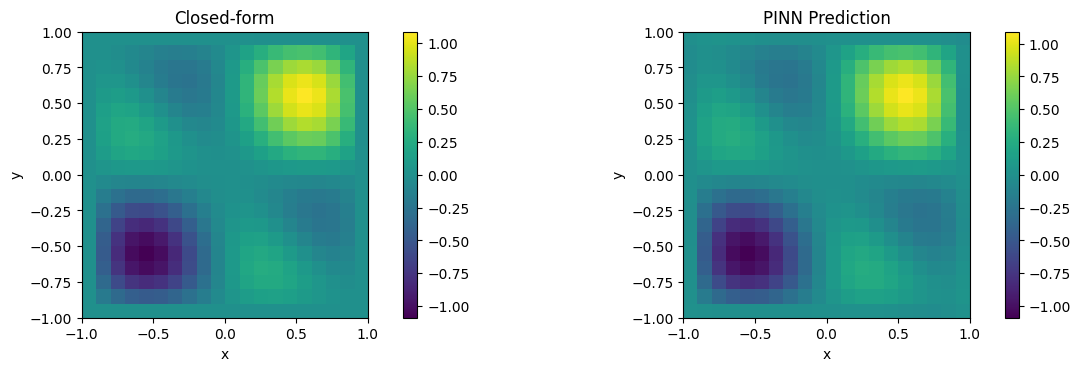

In [36]:
compare(PINN)